In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [2]:
def heaviside(x):
    """Heaviside function H(x) as described:
    1 for x > 0, 0 for x < 0, 0.5 for x == 0
    """
    return np.where(x > 0, 1, np.where(x < 0, 0, 0.5))

def dpli(signal_x, signal_y):
    """Compute the dPLI between two signals, signal_x and signal_y."""
    
    signal_x = np.array(signal_x)
    signal_y = np.array(signal_y)
    
    phase_diff = np.angle(signal_x) - np.angle(signal_y)
        
    h = heaviside(phase_diff)
    
    dpli_value = np.mean(h)
    
    return dpli_value

def add_noise(signal, snr_db):
    """Add noise to the signal based on the specified SNR (in dB)."""
    signal_power = np.mean(signal**2)

    noise_power = signal_power / (10**(snr_db / 10))

    noise = np.sqrt(noise_power) * np.random.randn(len(signal))
    
    return signal + noise

def correlation(signal_x, signal_y):
    """Compute the correlation coefficient between two signals."""

    cov = np.cov(signal_x, signal_y)[0, 1]

    std_x = np.std(signal_x)
    std_y = np.std(signal_y)

    return cov / (std_x * std_y)

def calculate_phase_amp(xa, xp, fs):
    """
    Processes two signals xa and xp using Continuous Wavelet Transform (CWT).

    Parameters:
    ----------
    xa : array-like
        Input signal A.
    xp : array-like
        Input signal P.
    fs : float
        Sampling frequency in Hz.

    Returns:
    -------
    phi_fp : 2D numpy.ndarray
        Phase of xp for frequencies 2-12 Hz. Shape: (11, time_points)
    A_fa : 2D numpy.ndarray
        Amplitude of xa for frequencies 20-80 Hz. Shape: (61, time_points)
    """
    
    f_p = np.arange(2, 13)   # 2 to 12 Hz (inclusive)
    f_a = np.arange(20, 81)  # 20 to 80 Hz (inclusive)
    
    frequencies = np.unique(np.concatenate((f_p, f_a)))
    
    frequencies = frequencies[(frequencies >= 2) & (frequencies <= 80)]
    
    wavelet = 'cmorl1.5-1.0'
    
    central_freq = pywt.central_frequency(wavelet)
    scales = central_freq * fs / frequencies
    
    Xa, _ = pywt.cwt(xa, scales, wavelet, sampling_period=1/fs)
    Xp, _ = pywt.cwt(xp, scales, wavelet, sampling_period=1/fs)
    
    phi = np.angle(Xp)  # Phase in radians
    
    idx_f_p = np.where((frequencies >= 2) & (frequencies <= 12))[0]
    idx_f_a = np.where((frequencies >= 20) & (frequencies <= 80))[0]
    
    phi_fp = phi[idx_f_p, :]
    
    A = np.abs(Xa)
    
    A_fa = A[idx_f_a, :]
    
    return phi_fp, A_fa

def calculate_phase_amp_1D(xa, xp, fs):
    """
    Processes two signals xa and xp using Continuous Wavelet Transform (CWT).

    Parameters:
    ----------
    xa : array-like
        Input signal A.
    xp : array-like
        Input signal P.
    fs : float
        Sampling frequency in Hz.

    Returns:
    -------
    phi : 1D numpy.ndarray
        Phase of xp. Shape: (time_points)
    A : 1D numpy.ndarray
        Amplitude of xa. Shape: (time_points)
    """
    
    f_p = np.arange(2, 13)   # 2 to 12 Hz (inclusive)
    f_a = np.arange(20, 81)  # 20 to 80 Hz (inclusive)
    
    frequencies = np.unique(np.concatenate((f_p, f_a)))
    
    frequencies = frequencies[(frequencies >= 2) & (frequencies <= 80)]
    
    wavelet = 'cmorl1.5-1.0'
    
    central_freq = pywt.central_frequency(wavelet)
    scales = central_freq * fs / frequencies
    
    Xa, _ = pywt.cwt(xa, scales, wavelet, sampling_period=1/fs)
    Xp, _ = pywt.cwt(xp, scales, wavelet, sampling_period=1/fs)
    
    phi = np.angle(Xp)  # Phase in radians
    
    A = np.abs(Xa)
        
    return phi, A

def calculate_pac_MLV(phi, A):
    """
    Calculate the Phase-Amplitude Coupling (PAC) between phase and amplitude matrices using the MVL method,
    utilizing vectorized operations for efficiency.
    
    Parameters
    ----------
    phi : ndarray of shape (T, Fp)
        Phase matrix, where T is the number of time points and Fp is the number of phase frequencies.
        phi(t, fp) gives the phase at time t for phase frequency fp.
    A : ndarray of shape (T, Fa)
        Amplitude matrix, where T is the number of time points and Fa is the number of amplitude frequencies.
        A(t, fa) gives the amplitude at time t for amplitude frequency fa.
    
    Returns
    -------
    PAC : ndarray of shape (Fa, Fp)
        PAC matrix, where each element PAC[fa, fp] is the PAC value between the fa-th amplitude frequency 
        and the fp-th phase frequency.
    """
    complex_matrix = A[:, :, np.newaxis] * np.exp(1j * phi[:, np.newaxis, :])

    PAC = np.abs(np.mean(complex_matrix, axis=0))

    return PAC


def circular_shift(x, shift_samples):
    """
    Perform circular shift on the signal by the specified number of samples.
    """
    return np.roll(x, shift_samples)

def ProxyHistogram(phi, A, num_bins):
    """
    Create a proxy histogram where the bins are defined based on `phi`,
    and the values in each bin are summed amplitudes `A`.

    Parameters:
    ----------
    phi : 1D numpy.ndarray
        Array of phase values (in radians). Shape: (time_points,)
    A : 1D numpy.ndarray
        Array of amplitude values. Shape: (time_points,)
    num_bins : int
        Number of bins to divide the phase range [-pi, pi] into.

    Returns:
    -------
    histogram : 1D numpy.ndarray
        Normalized histogram where each bin value is the summed amplitude
        of phases falling into that bin, divided by the total amplitude sum.
    bin_edges : 1D numpy.ndarray
        Edges of the bins used for the histogram.
    """
    bin_edges = np.linspace(-np.pi, np.pi, num_bins + 1)

    histogram = np.zeros(num_bins)

    for i in range(len(phi)):
        bin_index = np.digitize(phi[i], bin_edges) - 1 
        if 0 <= bin_index < num_bins:  
            histogram[bin_index] += A[i]

    total_sum = np.sum(histogram)
    if total_sum > 0:
        histogram = histogram / total_sum

    return histogram, bin_edges

def kl_divergence(P_samples, Q_samples, num_bins=50):
    """
    Compute the Kullback-Leibler Divergence D_KL(P || Q) between two distributions.

    Parameters:
    ----------
    P_samples : array-like
        Samples from distribution P.
    Q_samples : array-like
        Samples from distribution Q.
    num_bins : int, optional
        Number of bins to use for the histograms (default is 50).

    Returns:
    -------
    float
        The KL divergence D_KL(P || Q).
    """
    # Compute histograms for P and Q
    hist_P, bin_edges = np.histogram(P_samples, bins=num_bins, density=True)
    hist_Q, _ = np.histogram(Q_samples, bins=bin_edges, density=True)
    
    # Normalize histograms to get probabilities
    P = hist_P / np.sum(hist_P)
    Q = hist_Q / np.sum(hist_Q)
    
    # Ensure no zeros in Q for division (replace with small epsilon)
    Q = np.where(Q == 0, 1e-10, Q)
    P = np.where(P == 0, 1e-10, P)  # Handle P to avoid log(0)

    # Compute KL divergence
    kl_div = np.sum(P * np.log(P / Q))
    
    return kl_div

def calculate_pac_MI(phi, A, num_bins):
    """
    Calculate the PAC (Modulation Index) matrix for given phi and A arrays.

    Parameters:
    ----------
    phi : 2D numpy.ndarray
        Phase array of shape (time_points, phase_freqs)
    A : 2D numpy.ndarray
        Amplitude array of shape (time_points, amp_freqs)
    num_bins : int
        Number of bins to use in the ProxyHistogram.

    Returns:
    -------
    PAC : 2D numpy.ndarray
        PAC matrix of shape (amp_freqs, phase_freqs), representing the MI for each combination.
    """
    _, phase_freqs = phi.shape
    _, amp_freqs = A.shape

    PAC = np.zeros((amp_freqs, phase_freqs))

    U = np.ones(num_bins) / num_bins

    for f_a in range(amp_freqs):
        for f_p in range(phase_freqs):
            phi_1d = phi[:, f_p]
            A_1d = A[:, f_a]

            P, _ = ProxyHistogram(phi_1d, A_1d, num_bins)

            eps = 1e-10
            P = np.where(P <= 0, eps, P)

            D_KL_UP = np.sum(U * np.log(U / P))

            PAC[f_a, f_p] = D_KL_UP / np.log(num_bins)

    return PAC

## DPLI

In [3]:
fs = 10  
fc = 4  
t_max = 1 
sampling_rate = 500 
t = np.linspace(0, t_max, int(sampling_rate * t_max), endpoint=False)  

def x(t):
    """Generate signal x(t) = sin(2 * pi * fs * t)"""
    return np.sin(2 * np.pi * fs * t)

def y(t, t0):
    """Generate signal y(t) = sin(2 * pi * fs * (t - t0))"""
    return np.sin(2 * np.pi * fs * (t - t0))

def C(t):
    """Generate signal C(t) = sin(2 * pi * fc * t)"""
    return np.sin(2 * np.pi * fc * t)

def white_noise(size):
    """Generate white Gaussian noise with mean 0 and variance 1."""
    return np.random.normal(0, 1, size)

### Delay Effect

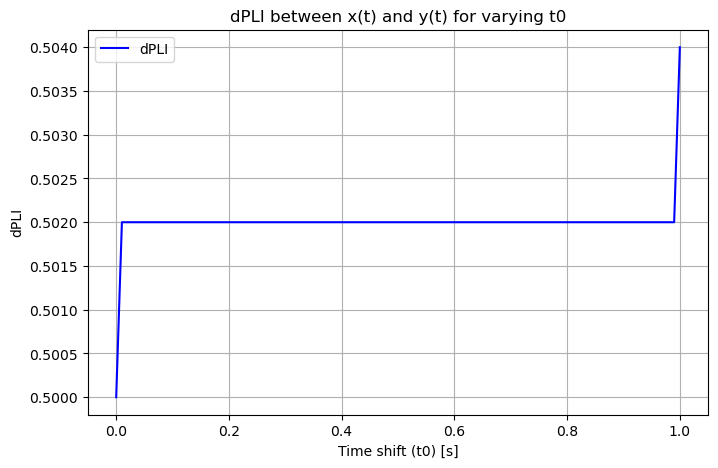

In [4]:
t0_values = np.linspace(0, t_max, num=100) 
dpli_values = []

for t0 in t0_values:
    signal_x = x(t)
    signal_y = y(t, t0)
    
    dpli_value = dpli(signal_x, signal_y)
    dpli_values.append(dpli_value)

plt.figure(figsize=(8, 5))
plt.plot(t0_values, dpli_values, label='dPLI', color='b')
plt.title('dPLI between x(t) and y(t) for varying t0')
plt.xlabel('Time shift (t0) [s]')
plt.ylabel('dPLI')
plt.grid(True)
plt.legend()
plt.show()

### Common Source Effect

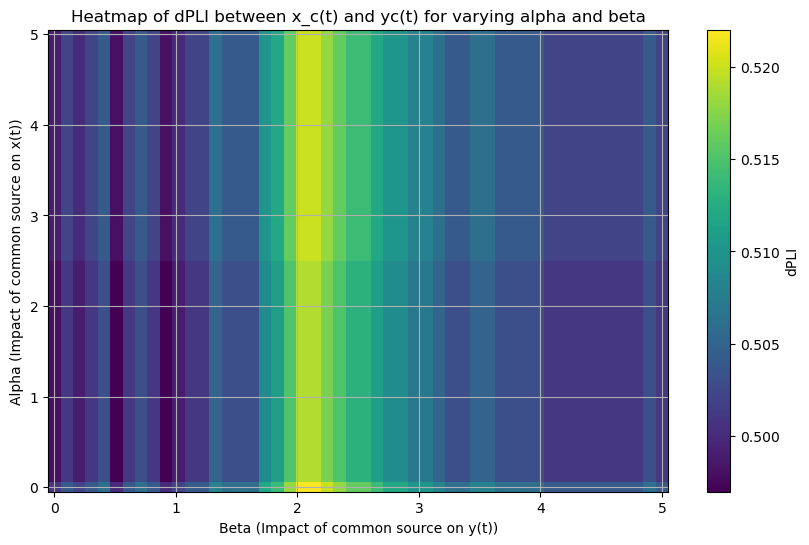

In [5]:
t0 = 0.002  
alpha_values = np.linspace(0, 5, 50)  
beta_values = np.linspace(0, 5, 50) 

dpli_matrix = np.zeros((len(alpha_values), len(beta_values)))

for i, alpha in enumerate(alpha_values):
    for j, beta in enumerate(beta_values):
        signal_xc = x(t) + alpha * C(t)
        signal_yc = y(t, t0) + beta * C(t)
        
        dpli_matrix[i, j] = dpli(signal_xc, signal_yc)

plt.figure(figsize=(10, 6))
plt.pcolormesh(beta_values, alpha_values, dpli_matrix)
plt.colorbar(label='dPLI')
plt.title('Heatmap of dPLI between x_c(t) and yc(t) for varying alpha and beta')
plt.xlabel('Beta (Impact of common source on y(t))')
plt.ylabel('Alpha (Impact of common source on x(t))')
plt.grid(True)
plt.show()

### Noise Effect

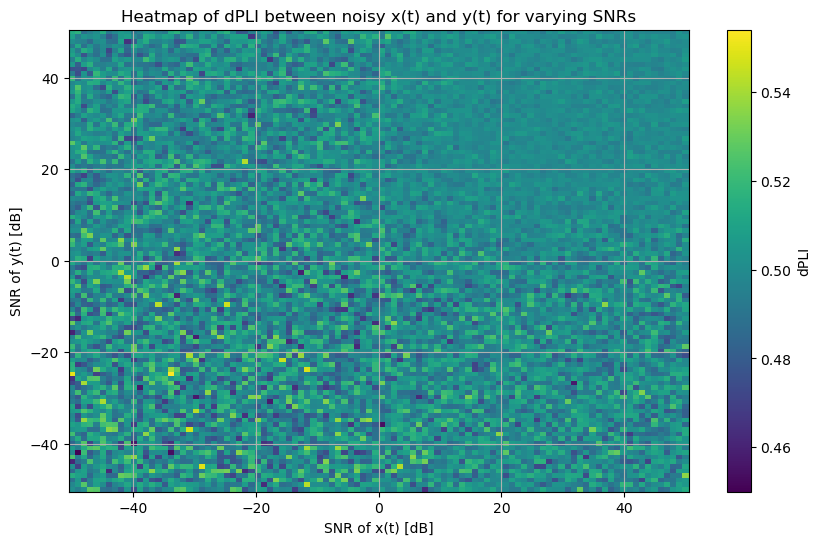

In [6]:
snr_values = np.linspace(-50, 50, 100)  # SNR values from -50 dB to 50 dB
dpli_matrix = np.zeros((len(snr_values), len(snr_values)))

for i, snr_x in enumerate(snr_values):
    for j, snr_y in enumerate(snr_values):
        signal_x = x(t)
        signal_y = y(t, t0)
        
        noisy_signal_x = add_noise(signal_x, snr_x)
        noisy_signal_y = add_noise(signal_y, snr_y)
        
        dpli_matrix[i, j] = dpli(noisy_signal_x, noisy_signal_y)

plt.figure(figsize=(10, 6))
plt.pcolormesh(snr_values, snr_values, dpli_matrix)
plt.colorbar(label='dPLI')
plt.title('Heatmap of dPLI between noisy x(t) and y(t) for varying SNRs')
plt.xlabel('SNR of x(t) [dB]')
plt.ylabel('SNR of y(t) [dB]')
plt.grid(True)
plt.show()

## Power-to-Power Correlation

In [7]:
def correlation(signal_x, signal_y):
    """Compute the correlation between two signals, signal_x and signal_y."""

    covariance = np.cov(signal_x, signal_y)[0, 1]
    
    std_x = np.std(signal_x)
    std_y = np.std(signal_y)
    
    correlation_value = covariance / (std_x * std_y)
    
    return correlation_value

### Delay Effect

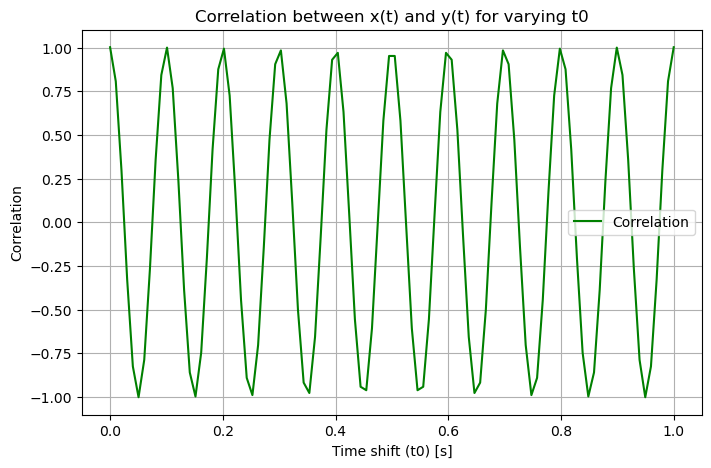

In [8]:
t0_values = np.linspace(0, t_max, num=100)  # Time shifts from 0 to 1 second
correlation_values = []

for t0 in t0_values:
    signal_x = x(t)
    signal_y = y(t, t0)
    
    correlation_value = correlation(signal_x, signal_y)
    correlation_values.append(correlation_value)

plt.figure(figsize=(8, 5))
plt.plot(t0_values, correlation_values, label='Correlation', color='g')
plt.title('Correlation between x(t) and y(t) for varying t0')
plt.xlabel('Time shift (t0) [s]')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.show()

### Common Source Effect (Similar to Previous Part)

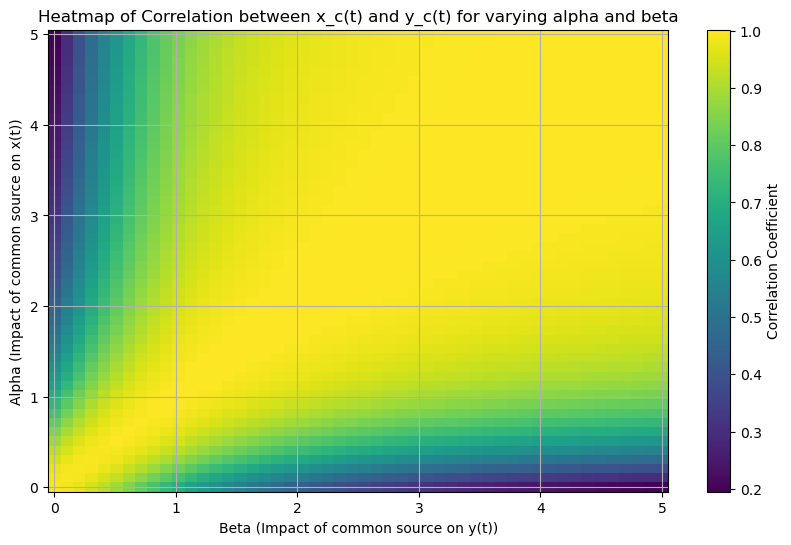

In [14]:
t0 = 0.002  

alpha_values = np.linspace(0, 5, 50)
beta_values = np.linspace(0, 5, 50)

dpli_matrix = np.zeros((len(alpha_values), len(beta_values)))

for i, alpha in enumerate(alpha_values):
    for j, beta in enumerate(beta_values):
        signal_xc = x(t) + alpha * C(t)
        signal_yc = y(t, t0) + beta * C(t)
        
        dpli_matrix[i, j] = correlation(signal_xc, signal_yc)

plt.figure(figsize=(10, 6))
plt.pcolormesh(beta_values, alpha_values, dpli_matrix, shading='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Heatmap of Correlation between x_c(t) and y_c(t) for varying alpha and beta')
plt.xlabel('Beta (Impact of common source on y(t))')
plt.ylabel('Alpha (Impact of common source on x(t))')
plt.grid(True)
plt.show()

### Common Source Effect

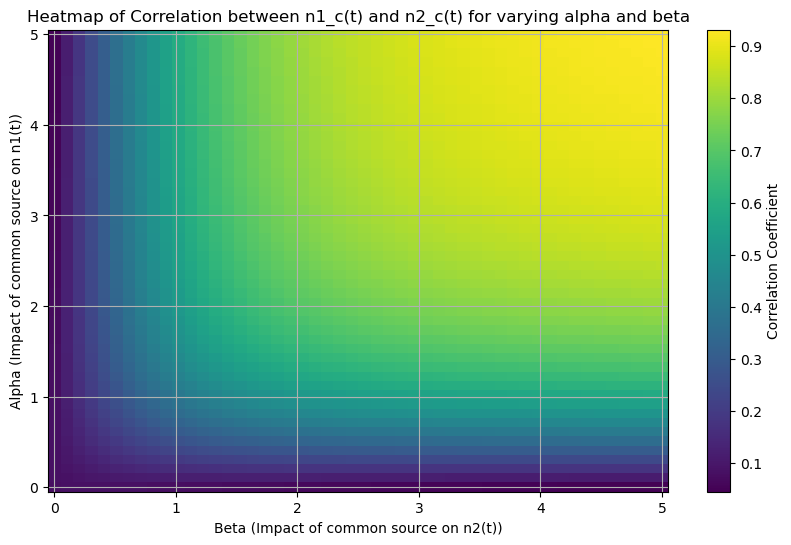

In [10]:
n1 = white_noise(len(t))
n2 = white_noise(len(t))

alpha_values = np.linspace(0, 5, 50)
beta_values = np.linspace(0, 5, 50)

correlation_matrix = np.zeros((len(alpha_values), len(beta_values)))

for i, alpha in enumerate(alpha_values):
    for j, beta in enumerate(beta_values):
        n1_c = n1 + alpha * C(t)
        n2_c = n2 + beta * C(t)
        
        correlation_matrix[i, j] = correlation(n1_c, n2_c)

plt.figure(figsize=(10, 6))
plt.pcolormesh(beta_values, alpha_values, correlation_matrix, shading='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Heatmap of Correlation between n1_c(t) and n2_c(t) for varying alpha and beta')
plt.xlabel('Beta (Impact of common source on n2(t))')
plt.ylabel('Alpha (Impact of common source on n1(t))')
plt.grid(True)
plt.show()

### Noise Effect (x,y)

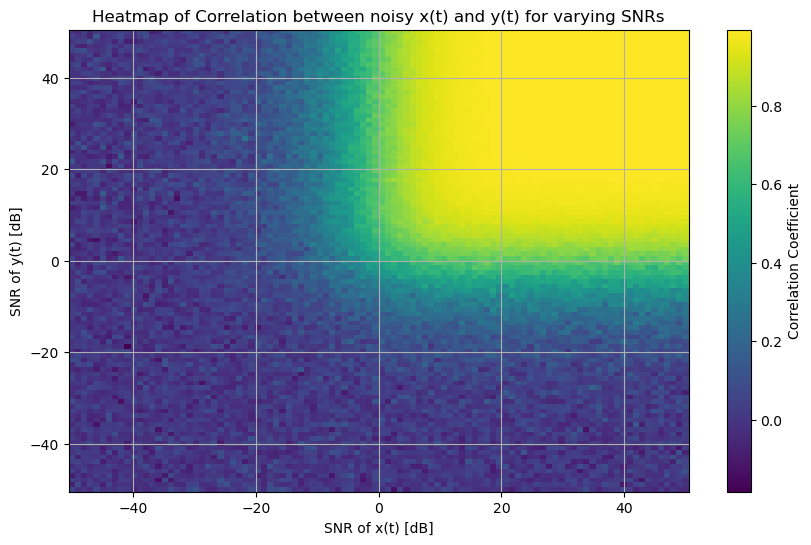

In [11]:
snr_values = np.linspace(-50, 50, 100) 
correlation_matrix = np.zeros((len(snr_values), len(snr_values)))

for i, snr_x in enumerate(snr_values):
    for j, snr_y in enumerate(snr_values):
        signal_x = x(t)
        signal_y = y(t,t0)

        noisy_signal_x = add_noise(signal_x, snr_x)
        noisy_signal_y = add_noise(signal_y, snr_y)
        
        correlation_matrix[i, j] = correlation(noisy_signal_x, noisy_signal_y)

plt.figure(figsize=(10, 6))
plt.pcolormesh(snr_values, snr_values, correlation_matrix, shading='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Heatmap of Correlation between noisy x(t) and y(t) for varying SNRs')
plt.xlabel('SNR of x(t) [dB]')
plt.ylabel('SNR of y(t) [dB]')
plt.grid(True)
plt.show()

### Noise Effect (n1_c, n2_c)

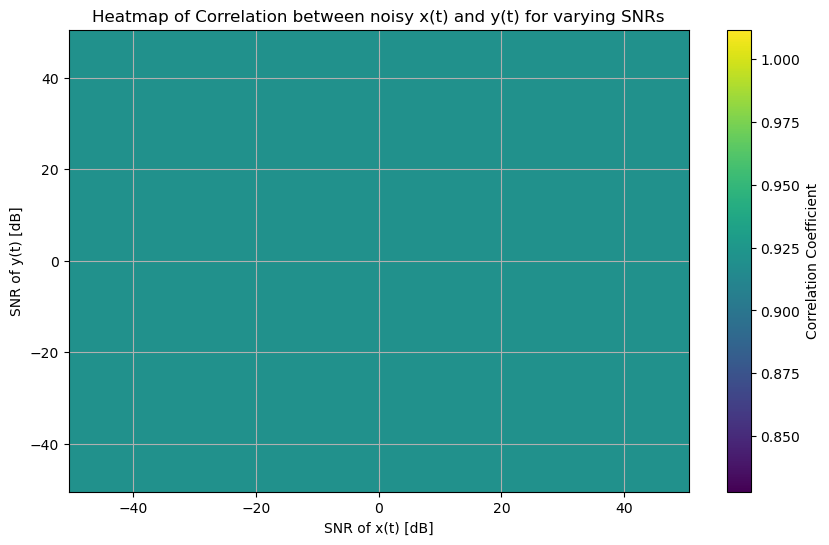

In [12]:
snr_values = np.linspace(-50, 50, 100) 

n1 = white_noise(len(t))
n2 = white_noise(len(t))

correlation_matrix = np.zeros((len(snr_values), len(snr_values)))

for i, snr_x in enumerate(snr_values):
    for j, snr_y in enumerate(snr_values):
        n1_c = n1 + alpha * C(t)
        n2_c = n2 + beta * C(t)
        
        correlation_matrix[i, j] = correlation(n1_c, n2_c)

plt.figure(figsize=(10, 6))
plt.pcolormesh(snr_values, snr_values, correlation_matrix, shading='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Heatmap of Correlation between noisy x(t) and y(t) for varying SNRs')
plt.xlabel('SNR of x(t) [dB]')
plt.ylabel('SNR of y(t) [dB]')
plt.grid(True)
plt.show()

## PAC

In [13]:
def generate_signals(kp, ka, fp, f_amp, chi, sigma):
    fs = 500
    t = np.linspace(0, 1, fs)
    
    noise1 = np.random.normal(0, 1, len(t)) * sigma
    noise2 = np.random.normal(0, 1, len(t)) * sigma
    
    xp = kp * np.cos(2 * np.pi * fp * t) + noise1
    xa = ka * ((1 - chi) * np.cos(2 * np.pi * fp * t) + (chi + 1) / 2) * np.cos(2 * np.pi * f_amp * t) + noise2
    
    return t, xp, xa

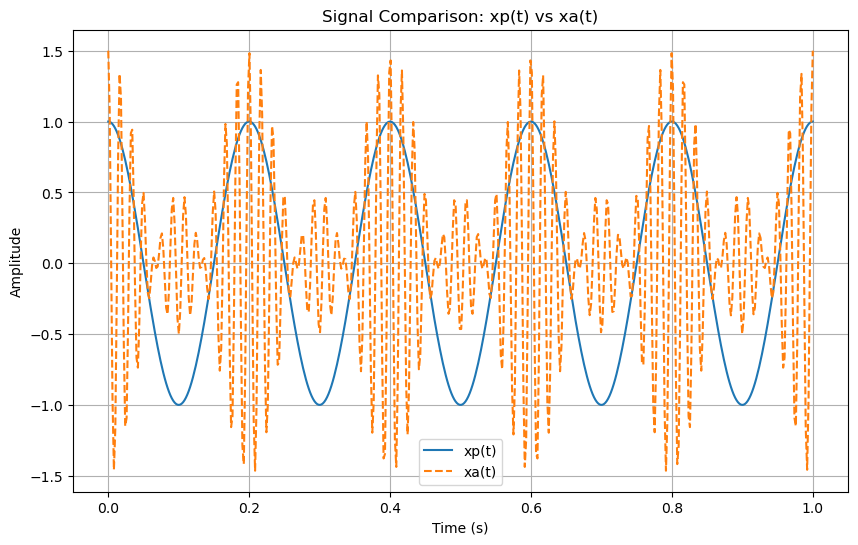

In [14]:
kp = 1
ka = 1
fp = 5
f_amp = 60
chi = 0
sigma = 0

fs = 500

t, xp, xa = generate_signals(kp, ka, fp, f_amp, chi, sigma)

plt.figure(figsize=(10, 6))
plt.plot(t, xp, label='xp(t)')
plt.plot(t, xa, label='xa(t)', linestyle='--')
plt.title('Signal Comparison: xp(t) vs xa(t)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

### MLV

Different $\chi$ values for MLV

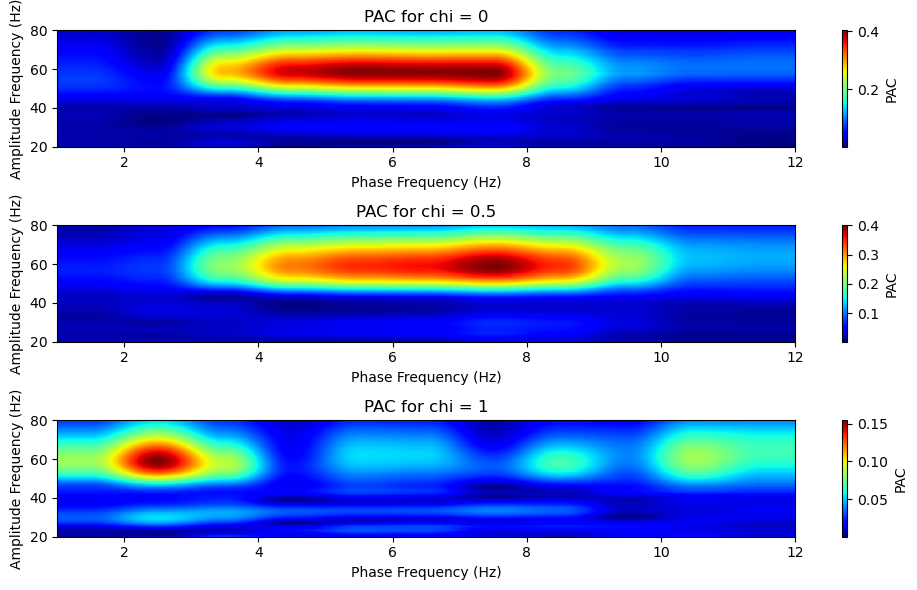

In [15]:
kp = 1
ka = 1
fp = 5
f_amp = 60
chi_values = [0, 0.5, 1]
sigma = 0.5

PAC_results = {}

for chi in chi_values:
    t, xp, xa = generate_signals(kp, ka, fp, f_amp, chi, sigma)

    phi, A = calculate_phase_amp(xa, xp, fs)
    
    PAC = calculate_pac_MLV(phi.T, A.T)
    
    PAC_results[chi] = PAC

plt.figure(figsize=(10, 6))

for idx, chi in enumerate(chi_values):
    plt.subplot(3, 1, idx + 1)
    plt.imshow(PAC_results[chi], aspect='auto', origin='lower', cmap='jet', extent=[1, 12, 20, 80])
    plt.colorbar(label='PAC')
    plt.title(f'PAC for chi = {chi}')
    plt.xlabel('Phase Frequency (Hz)')
    plt.ylabel('Amplitude Frequency (Hz)')

plt.tight_layout()
plt.show()

Different $\sigma$ values for MLV

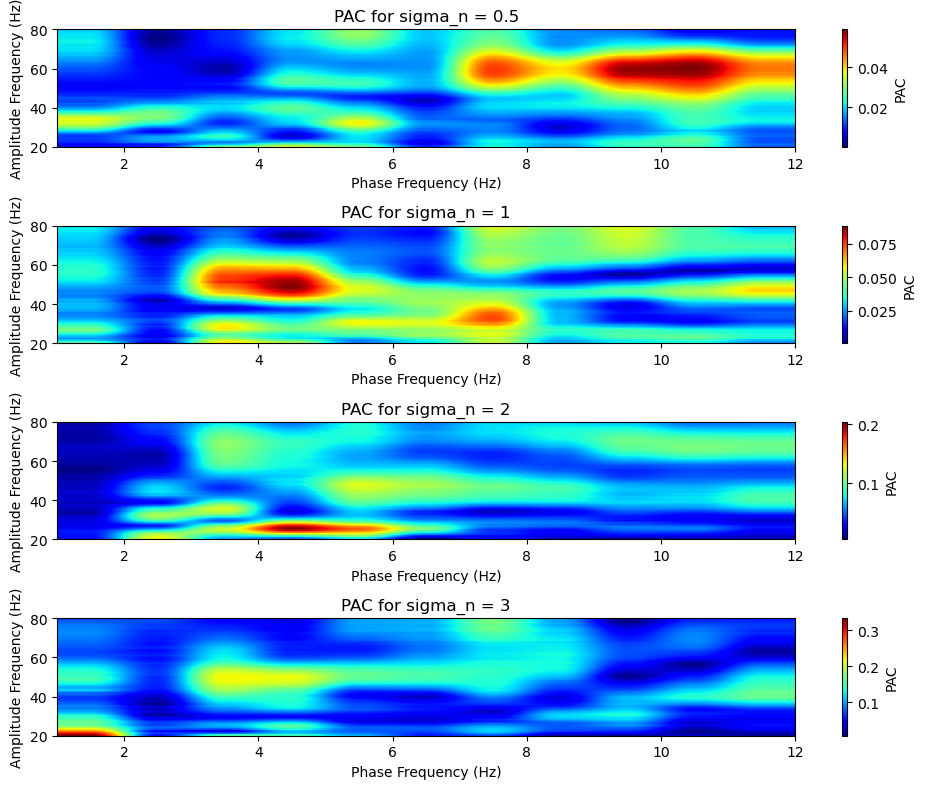

In [16]:
kp = 1
ka = 1
fp = 5
f_amp = 60
chi = 0 
sigma_values = [0.5, 1, 2, 3] 

PAC_results_sigma = {}

for sigma in sigma_values:
    t, xp, xa = generate_signals(kp, ka, fp, f_amp, chi, sigma)
    
    phi, A = calculate_phase_amp(xp, xa,fs)
    
    PAC = calculate_pac_MLV(phi.T, A.T)
    
    PAC_results_sigma[sigma] = PAC

plt.figure(figsize=(10, 8))

for idx, sigma in enumerate(sigma_values):
    plt.subplot(4, 1, idx + 1)
    plt.imshow(PAC_results_sigma[sigma], aspect='auto', origin='lower', cmap='jet', extent=[1, 12, 20, 80])
    plt.colorbar(label='PAC')
    plt.title(f'PAC for sigma_n = {sigma}')
    plt.xlabel('Phase Frequency (Hz)')
    plt.ylabel('Amplitude Frequency (Hz)')

plt.tight_layout()
plt.show()

Circular Shift for MLV

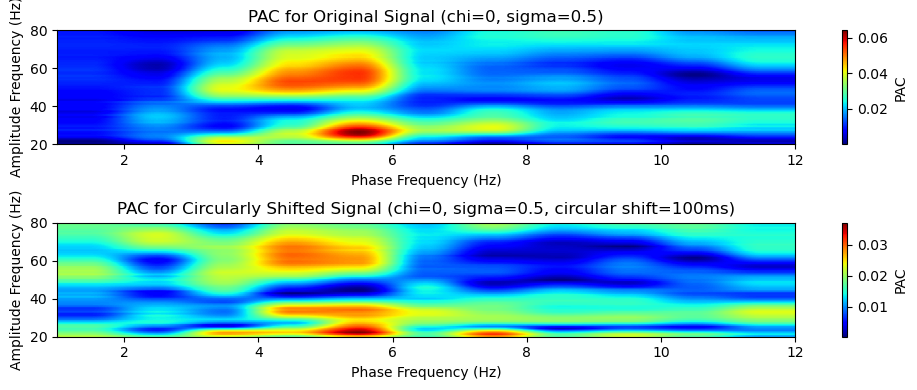

In [30]:
kp = 1
ka = 1
fp = 5
f_amp = 60
chi = 0
sigma = 0.5

t, xp, xa = generate_signals(kp, ka, fp, f_amp, chi, sigma)

phi, A = calculate_phase_amp(xp, xa, fs)
PAC_original = calculate_pac_MLV(phi.T, A.T)

shift_samples = int(0.1 * 500)  # fs = 500 Hz, so shift by 100 ms

xp_shifted = circular_shift(xp, shift_samples)
xa_shifted = circular_shift(xa, shift_samples)

phi_shifted, A_shifted = calculate_phase_amp(xp_shifted, xa_shifted, fs)
PAC_shifted = calculate_pac_MLV(phi_shifted.T, A_shifted.T)

plt.figure(figsize=(10, 4))

plt.subplot(2, 1, 1)
plt.imshow(PAC_original, aspect='auto', origin='lower', cmap='jet', extent=[1, 12, 20, 80])
plt.colorbar(label='PAC')
plt.title('PAC for Original Signal (chi=0, sigma=0.5)')
plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amplitude Frequency (Hz)')

plt.subplot(2, 1, 2)
plt.imshow(PAC_shifted, aspect='auto', origin='lower', cmap='jet', extent=[1, 12, 20, 80])
plt.colorbar(label='PAC')
plt.title('PAC for Circularly Shifted Signal (chi=0, sigma=0.5, circular shift=100ms)')
plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amplitude Frequency (Hz)')

plt.tight_layout()
plt.show()

### MI

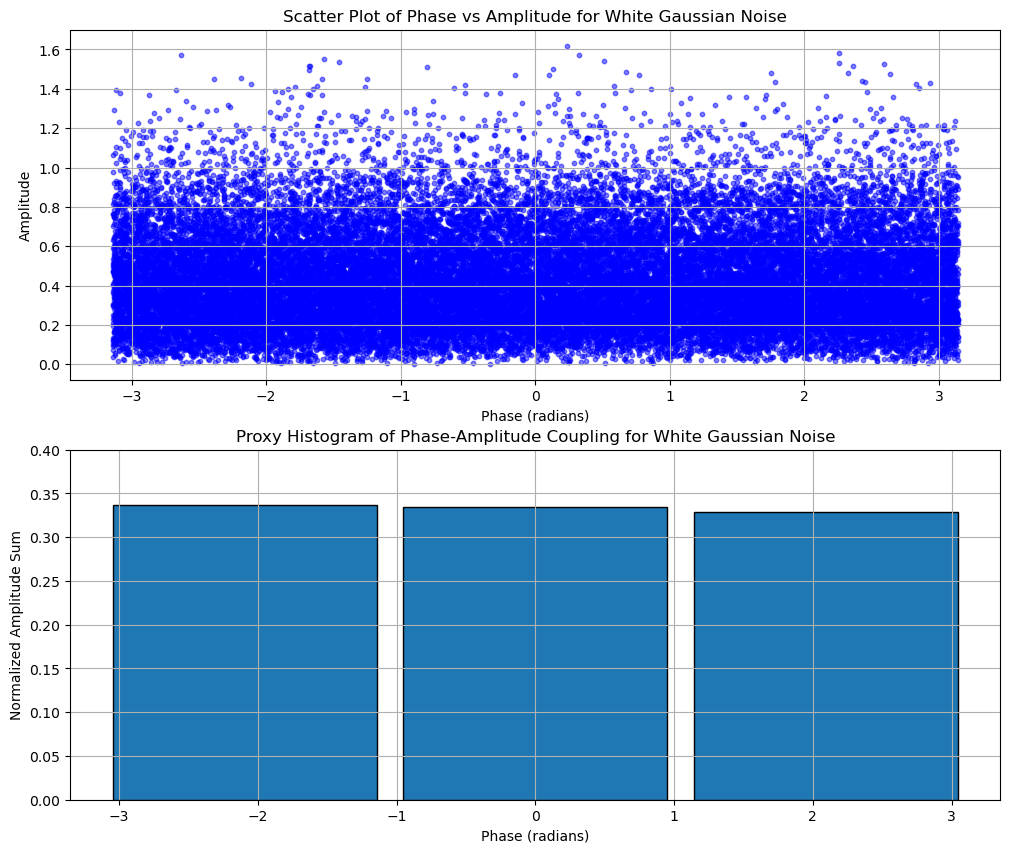

In [35]:
xa = np.random.normal(0, 1, len(t)) 
xp = np.random.normal(0, 1, len(t))  

phi_flatten, A_flatten = calculate_phase_amp_1D(xa, xp, fs)

phi_flatten = phi_flatten.flatten()
A_flatten = A_flatten.flatten()

num_bins = 3  
histogram, bin_edges = ProxyHistogram(phi_flatten, A_flatten, num_bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.scatter(phi_flatten, A_flatten, s=10, alpha=0.5, color='blue')
plt.title('Scatter Plot of Phase vs Amplitude for White Gaussian Noise')
plt.xlabel('Phase (radians)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.bar(bin_centers, histogram, width=np.diff(bin_edges)/1.1, edgecolor='black', align='center')
plt.ylim([0,0.4])
plt.title('Proxy Histogram of Phase-Amplitude Coupling for White Gaussian Noise')
plt.xlabel('Phase (radians)')
plt.ylabel('Normalized Amplitude Sum')
plt.grid(True)
plt.show()

In [23]:
np.random.seed(42)
gaussian_1 = np.random.normal(0, 1, 1000)  # Gaussian distribution N(0, 1)
gaussian_2 = np.random.normal(1, 1, 1000)  # Gaussian distribution N(1, 1)

uniform_1 = np.random.uniform(-1, 1, 1000)  # Uniform distribution U(-1, 1)
uniform_2 = np.random.uniform(0, 2, 1000)   # Uniform distribution U(0, 2)

kl_gaussian_same = kl_divergence(gaussian_1, gaussian_1)
kl_uniform_same = kl_divergence(uniform_1, uniform_1)

kl_gaussian_diff = kl_divergence(gaussian_1, gaussian_2)
kl_uniform_diff = kl_divergence(uniform_1, uniform_2)

# Display results
print("KL Divergence Between Homogeneous Distributions:")
print(f"Gaussian (N(0,1) vs N(0,1)): {kl_gaussian_same:.4f}")
print(f"Uniform (U(-1,1) vs U(-1,1)): {kl_uniform_same:.4f}")

print("\nKL Divergence Between Heterogeneous Distributions:")
print(f"Gaussian (N(0,1) vs N(1,1)): {kl_gaussian_diff:.4f}")
print(f"Uniform (U(-1,1) vs U(0,2)): {kl_uniform_diff:.4f}")

KL Divergence Between Homogeneous Distributions:
Gaussian (N(0,1) vs N(0,1)): 0.0000
Uniform (U(-1,1) vs U(-1,1)): 0.0000

KL Divergence Between Heterogeneous Distributions:
Gaussian (N(0,1) vs N(1,1)): 0.8806
Uniform (U(-1,1) vs U(0,2)): 9.1953


Different $\chi$ values for MI

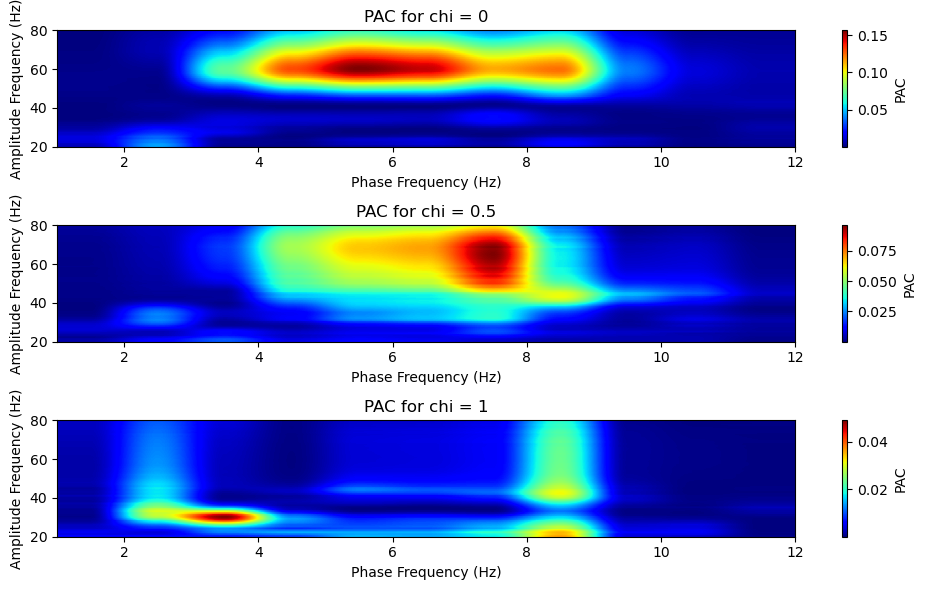

In [27]:
num_bins = 3

kp = 1
ka = 1
fp = 5
f_amp = 60
chi_values = [0, 0.5, 1]
sigma = 0.5

PAC_results = {}

for chi in chi_values:
    t, xp, xa = generate_signals(kp, ka, fp, f_amp, chi, sigma)

    phi, A = calculate_phase_amp(xa, xp, fs)
    
    PAC = calculate_pac_MI(phi.T, A.T, num_bins)
    
    PAC_results[chi] = PAC

plt.figure(figsize=(10, 6))

for idx, chi in enumerate(chi_values):
    plt.subplot(3, 1, idx + 1)
    plt.imshow(PAC_results[chi], aspect='auto', origin='lower', cmap='jet', extent=[1, 12, 20, 80])
    plt.colorbar(label='PAC')
    plt.title(f'PAC for chi = {chi}')
    plt.xlabel('Phase Frequency (Hz)')
    plt.ylabel('Amplitude Frequency (Hz)')

plt.tight_layout()
plt.show()

Different $\sigma$ values for MI

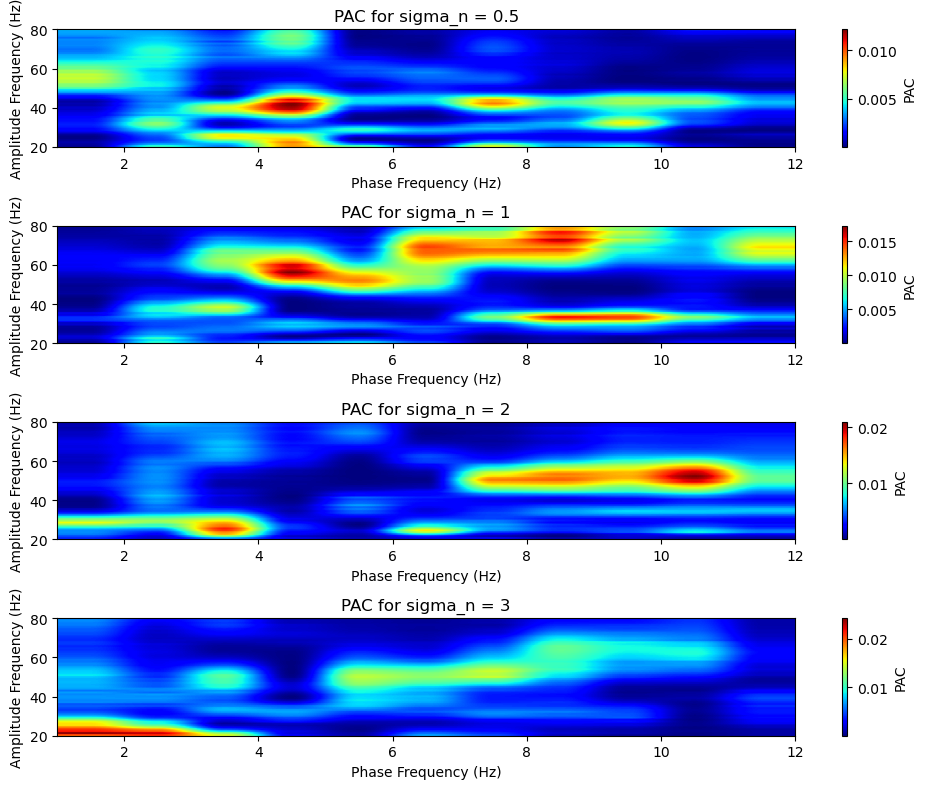

In [28]:
kp = 1
ka = 1
fp = 5
f_amp = 60
chi = 0 
sigma_values = [0.5, 1, 2, 3] 

PAC_results_sigma = {}

for sigma in sigma_values:
    t, xp, xa = generate_signals(kp, ka, fp, f_amp, chi, sigma)
    
    phi, A = calculate_phase_amp(xp, xa,fs)
    
    PAC = calculate_pac_MI(phi.T, A.T, num_bins)
    
    PAC_results_sigma[sigma] = PAC

plt.figure(figsize=(10, 8))

for idx, sigma in enumerate(sigma_values):
    plt.subplot(4, 1, idx + 1)
    plt.imshow(PAC_results_sigma[sigma], aspect='auto', origin='lower', cmap='jet', extent=[1, 12, 20, 80])
    plt.colorbar(label='PAC')
    plt.title(f'PAC for sigma_n = {sigma}')
    plt.xlabel('Phase Frequency (Hz)')
    plt.ylabel('Amplitude Frequency (Hz)')

plt.tight_layout()
plt.show()

Circular Shift for MI

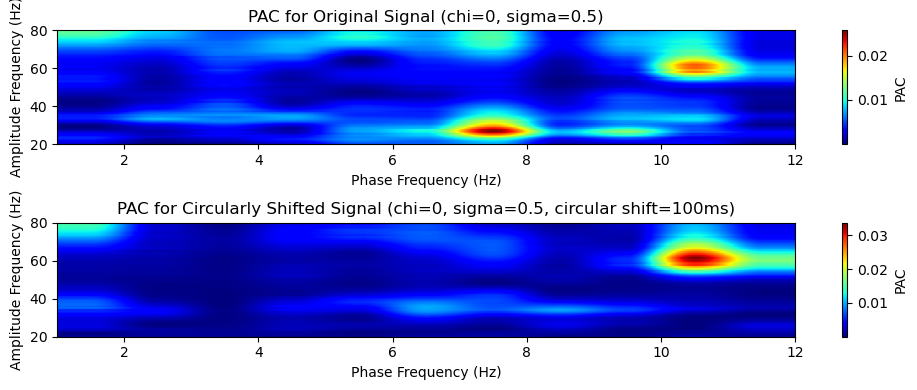

In [31]:
kp = 1
ka = 1
fp = 5
f_amp = 60
chi = 0
sigma = 0.5

t, xp, xa = generate_signals(kp, ka, fp, f_amp, chi, sigma)

phi, A = calculate_phase_amp(xp, xa, fs)
PAC_original = calculate_pac_MI(phi.T, A.T, num_bins)

shift_samples = int(0.1 * 500)  # fs = 500 Hz, so shift by 100 ms

xp_shifted = circular_shift(xp, shift_samples)
xa_shifted = circular_shift(xa, shift_samples)

phi_shifted, A_shifted = calculate_phase_amp(xp_shifted, xa_shifted, fs)
PAC_shifted = calculate_pac_MI(phi_shifted.T, A_shifted.T, num_bins)

plt.figure(figsize=(10, 4))

plt.subplot(2, 1, 1)
plt.imshow(PAC_original, aspect='auto', origin='lower', cmap='jet', extent=[1, 12, 20, 80])
plt.colorbar(label='PAC')
plt.title('PAC for Original Signal (chi=0, sigma=0.5)')
plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amplitude Frequency (Hz)')

plt.subplot(2, 1, 2)
plt.imshow(PAC_shifted, aspect='auto', origin='lower', cmap='jet', extent=[1, 12, 20, 80])
plt.colorbar(label='PAC')
plt.title('PAC for Circularly Shifted Signal (chi=0, sigma=0.5, circular shift=100ms)')
plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amplitude Frequency (Hz)')

plt.tight_layout()
plt.show()

### Common Source Effect

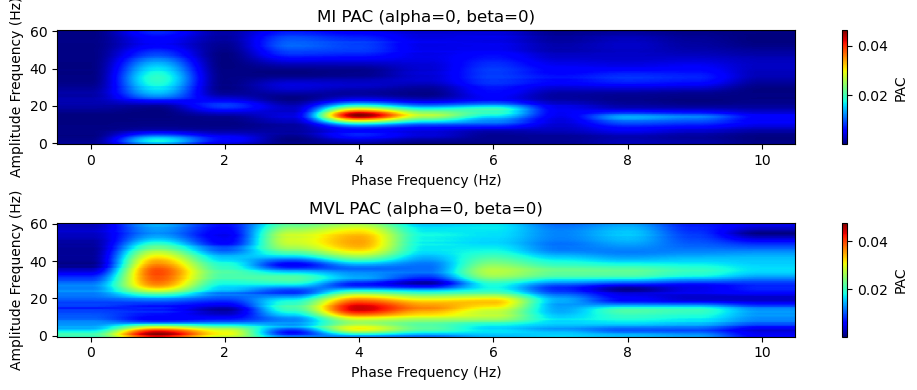

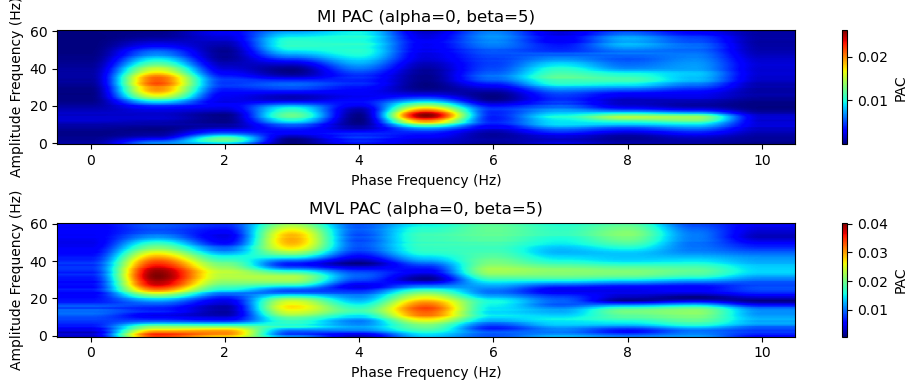

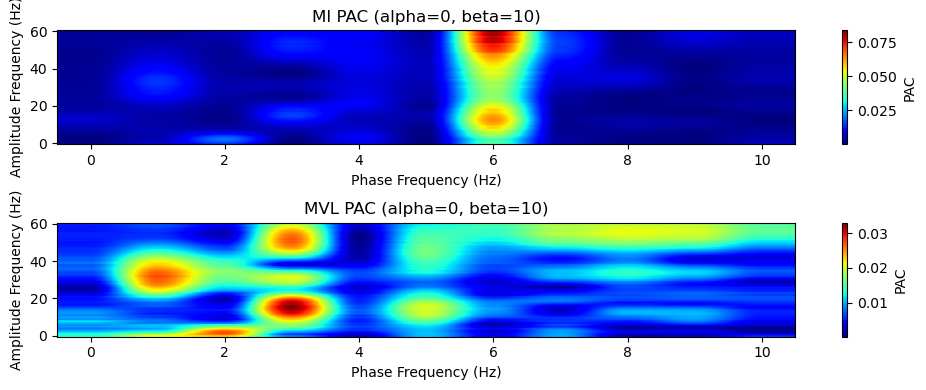

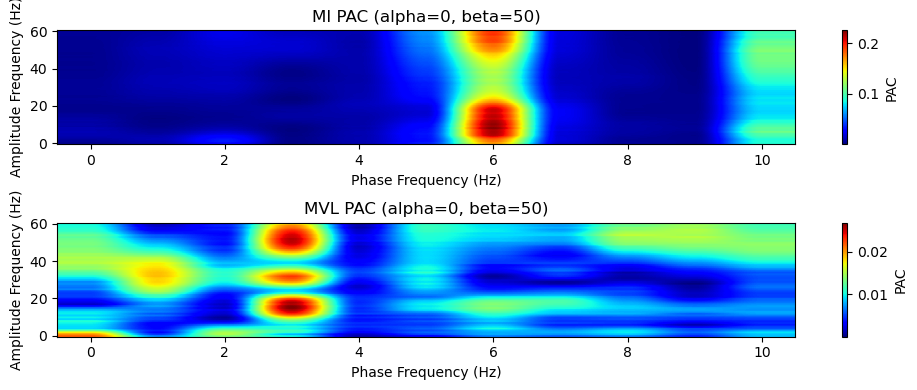

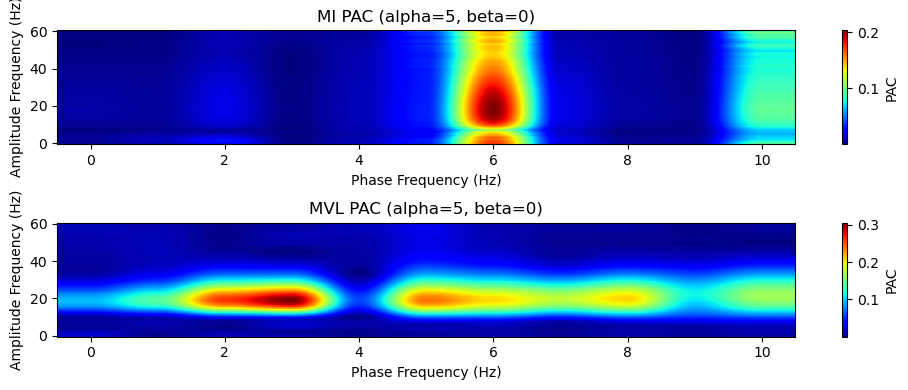

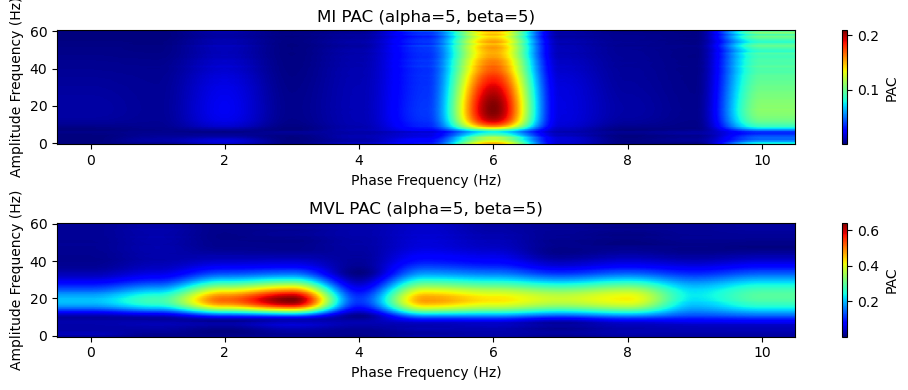

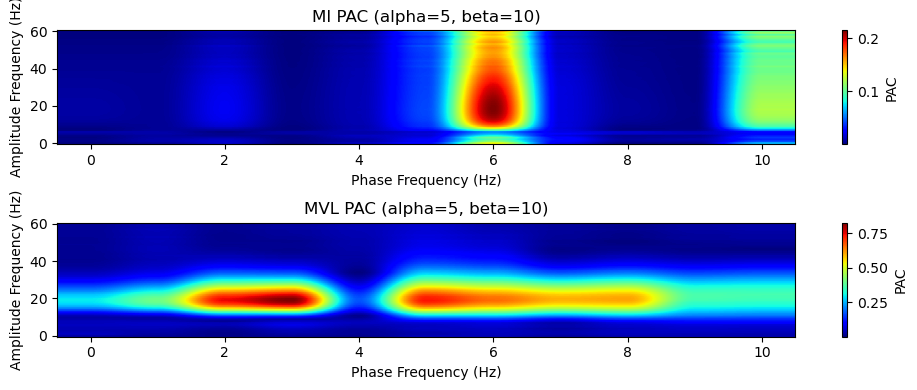

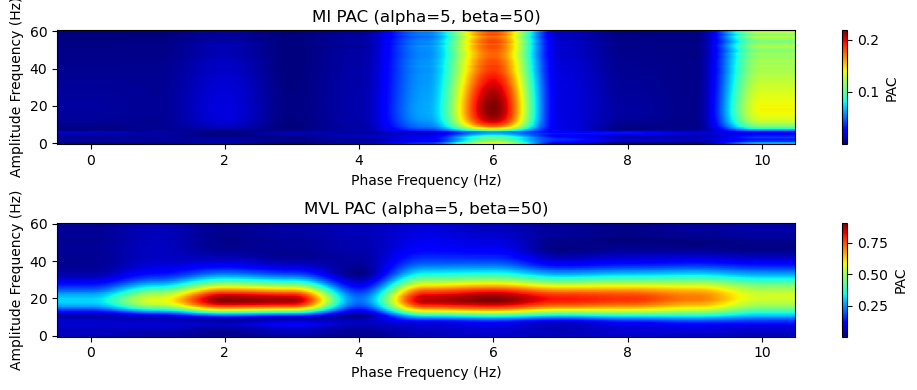

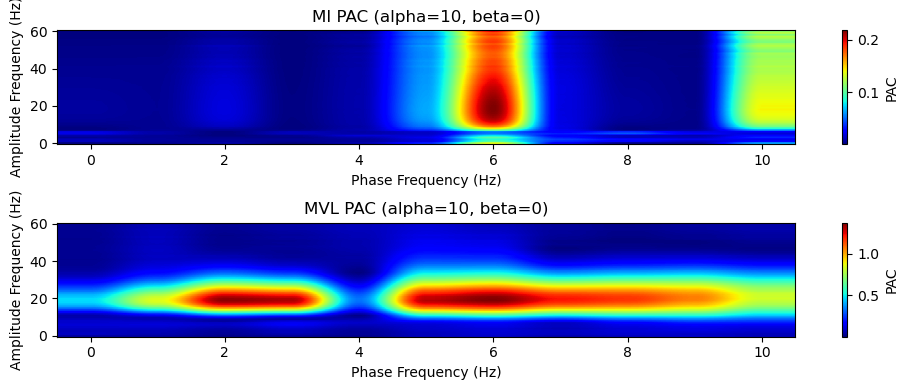

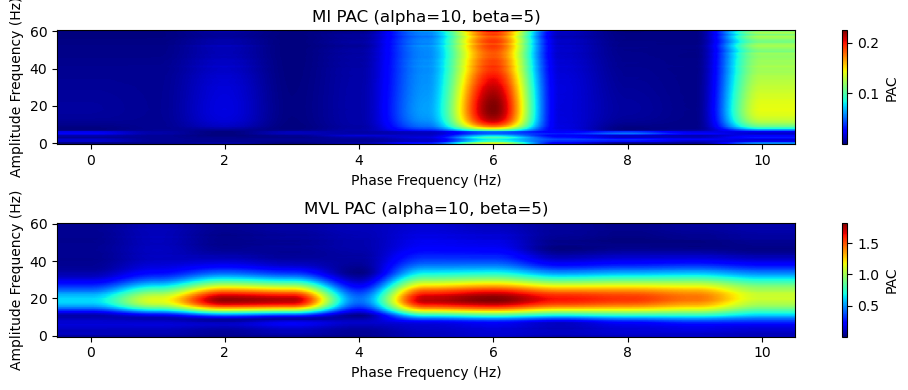

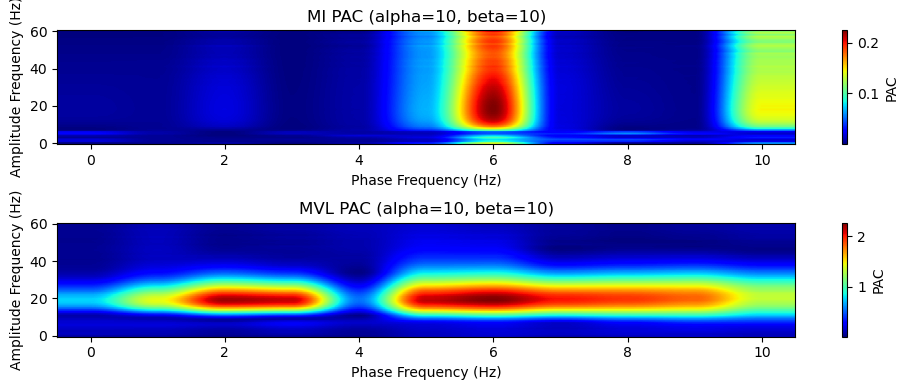

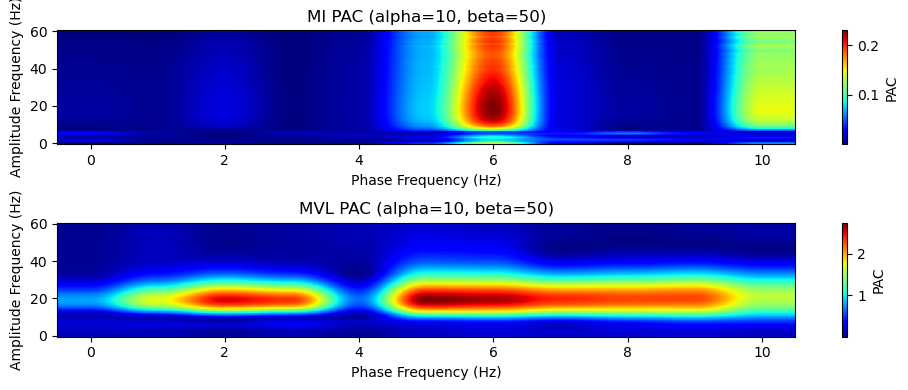

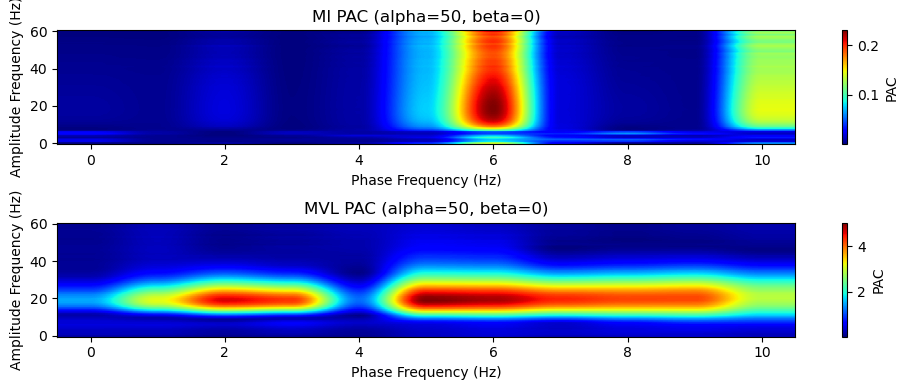

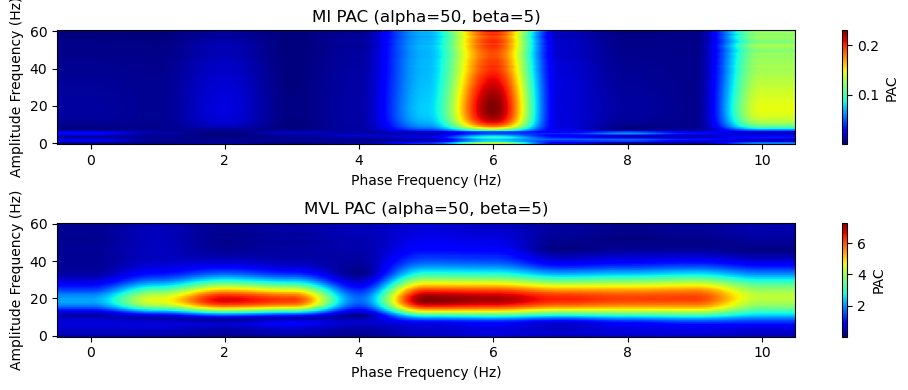

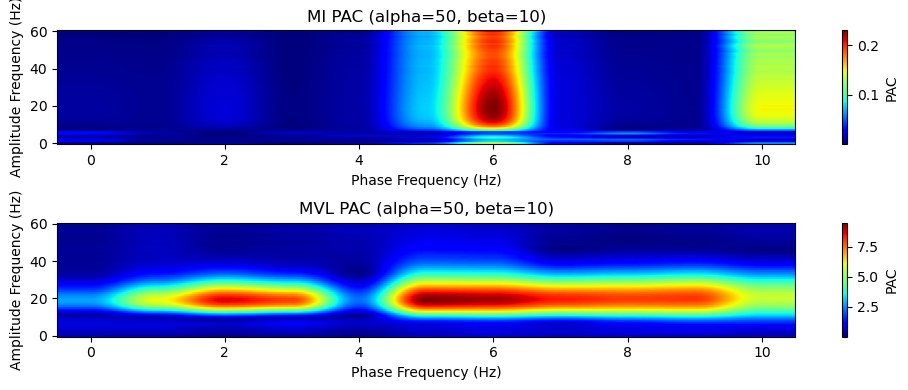

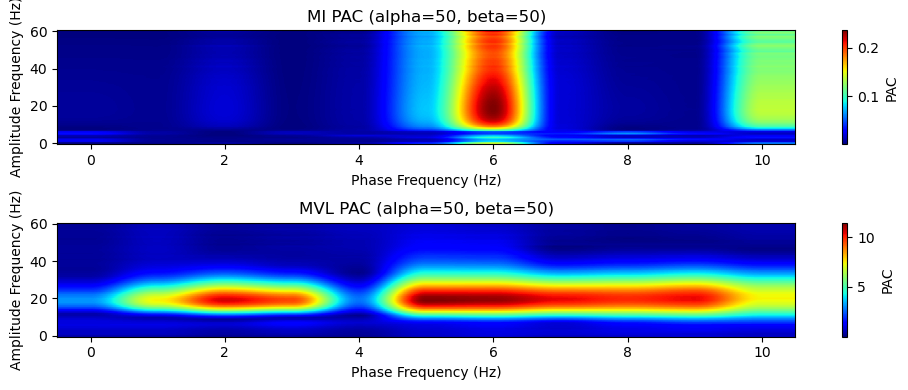

In [37]:
kp = 1
ka = 1
fp = 5
f_amp = 60
chi = 0
sigma = 0.5
f_cs = 40

alpha_values = [0, 5, 10, 50]
beta_values = [0, 5, 10, 50]

results_PAC_MI = {}
results_PAC_MLV = {}

t, xp, xa = generate_signals(kp, ka, fp, f_amp, chi, sigma)

for alpha in alpha_values:
    for beta in beta_values:
        
        xp += alpha * np.cos(2 * np.pi * f_cs * t)
        xa += beta * np.cos(2 * np.pi * f_cs * t)

        phi, A = calculate_phase_amp(xp, xa, fs)

        PAC_MLV = calculate_pac_MLV(phi.T, A.T)
        PAC_MI = calculate_pac_MI(phi.T, A.T, num_bins)

        results_PAC_MLV[(alpha, beta)] = PAC_MLV
        results_PAC_MI[(alpha, beta)] = PAC_MI


for alpha in alpha_values:
    for beta in beta_values:
        plt.figure(figsize=(10, 4))
        plt.subplot(2, 1, 1)
        plt.imshow(results_PAC_MI[(alpha, beta)], aspect='auto', origin='lower', cmap='jet')
        plt.title(f'MI PAC (alpha={alpha}, beta={beta})')
        plt.colorbar(label='PAC')
        plt.xlabel('Phase Frequency (Hz)')
        plt.ylabel('Amplitude Frequency (Hz)')

        plt.subplot(2, 1, 2)
        plt.imshow(results_PAC_MLV[(alpha, beta)], aspect='auto', origin='lower', cmap='jet')
        plt.title(f'MVL PAC (alpha={alpha}, beta={beta})')
        plt.colorbar(label='PAC')
        plt.xlabel('Phase Frequency (Hz)')
        plt.ylabel('Amplitude Frequency (Hz)')

        plt.tight_layout()
        plt.show()